# EXPLORATION 18 : 문자를 읽을 수 있는 딥러닝

## 준비한 데이터

- OCR에 사용할 이미지 파일 7장

## 서비스명 : 영어 간판 OCR
- 서비스 목적 : 추후 영어간판 자동번역을 위해 간판 인식단계부터 테스팅하기 위함
- 모델 평가기준 : 다양한 종류의 간판을 얼마나 잘 인식하는가 ?

In [1]:
from google.cloud import vision
import io
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/sign'
file_list = os.listdir(img_dir)
file_list

['4.jpg', '5.jpg', '6.jpg', '3.jpg', '1.jpg', '7.jpg', '2.jpg']

## OCR 모델 테스트

## 1. Keras-OCR

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


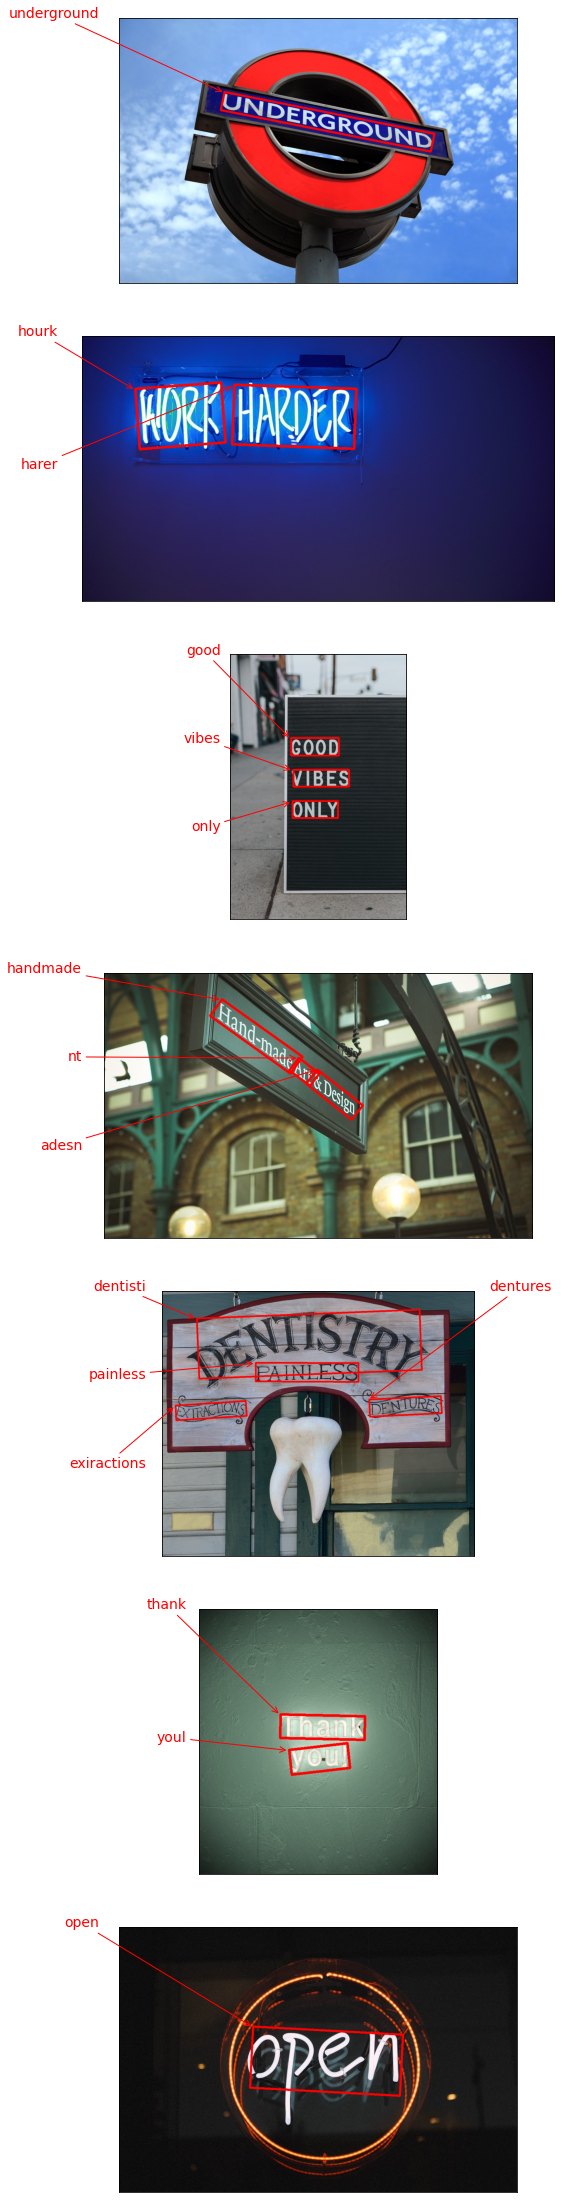

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2. Google OCR API

In [5]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [6]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[4.jpg]
Texts:

"UNDERGROUND
"

"UNDERGROUND"
bounds: (336,244),(1010,377),(1001,424),(327,291)

[5.jpg]
Texts:

"HORK HARDER
"

"HORK"

"HARDER"
bounds: (424,128),(727,128),(727,303),(424,303)

[6.jpg]
Texts:

"GOOD
VIBES
ONLY
"

"GOOD"

"VIBES"

"ONLY"
bounds: (228,536),(387,537),(387,592),(228,591)

[3.jpg]
Texts:

"Hand-made Art& Design
"

"Hand-made"

"Art&"

"Design"
bounds: (684,329),(769,392),(735,439),(649,376)

[1.jpg]
Texts:

"DENTISTA
PAINLESS
EXTRACTIONS
DENTURES
"

"DENTISTA"

"PAINLESS"

"EXTRACTIONS"

"DENTURES"
bounds: (838,442),(1149,438),(1150,511),(839,515)

[7.jpg]
Texts:

"Thank
yeu!
"

"Thank"

"yeu!"
bounds: (232,360),(399,355),(402,442),(235,447)

[2.jpg]
Texts:

"open
OP
"

"open"

"OP"
bounds: (416,339),(627,344),(623,505),(412,500)



## 3. Tesseract

In [7]:
import pytesseract
from PIL import Image
from pytesseract import Output

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[4.jpg]

Done
[5.jpg]
WORK moe j

Done
[6.jpg]

Done
[3.jpg]
Cannot recognize characters from 3.jpg
[1.jpg]
j

Done
[7.jpg]
Cannot recognize characters from 7.jpg
[2.jpg]
ie

Done


## OCR 모델 비교분석하기

In [9]:
def compare_ocr(file):
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

### 1. 기울어진 명확한 간판

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


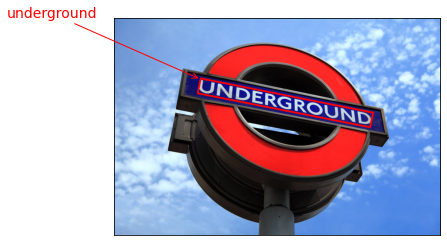


[Google OCR]
Texts:

"UNDERGROUND
"

"UNDERGROUND"
bounds: (336,244),(1010,377),(1001,424),(327,291)

[Tesseract]

Done


In [11]:
compare_ocr('4.jpg')

기울어진 명확한 간판에서 케라스는 정확하게 읽어냈고  
구글도 정확하게 읽어낸 반면 테서렉트는 아무것도 못 읽어낸 것을 볼 수 있다.

### 2. 글씨가 고르지 못한 간판

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


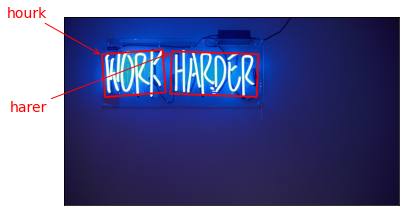


[Google OCR]
Texts:

"HORK HARDER
"

"HORK"

"HARDER"
bounds: (424,128),(727,128),(727,303),(424,303)

[Tesseract]
WORK moe j

Done


In [10]:
compare_ocr('5.jpg')

이번엔 희안하게도 테서렉트만 WORK를 읽어냈고  
케라스랑 구글 전부 WORK를 읽어내지 못한 결과를 볼 수 있는데  
HARDER는 그 반대로 구글과 케라스만 읽어냈고 테서렉트는 못읽어낸 걸 볼 수 있다.

### 3. 정면의 명확한 간판

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


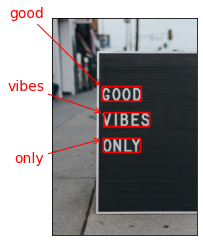


[Google OCR]
Texts:

"GOOD
VIBES
ONLY
"

"GOOD"

"VIBES"

"ONLY"
bounds: (228,536),(387,537),(387,592),(228,591)

[Tesseract]

Done


In [11]:
compare_ocr('6.jpg')

정면으로 또렷하게 글씨가 써있는 간판으로 비교해보니  
케라스와 구글은 잘 인식했는데 왜인지 모르겠지만  
테서렉트는 인식을 못하는 모습이다. 

### 4. 기울어진 촘촘한 글씨의 간판

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


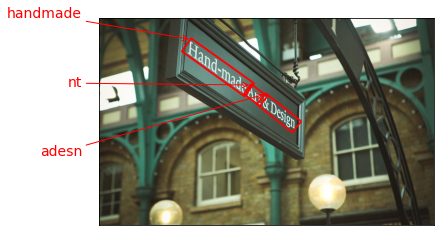


[Google OCR]
Texts:

"Hand-made Art& Design
"

"Hand-made"

"Art&"

"Design"
bounds: (684,329),(769,392),(735,439),(649,376)

[Tesseract]


SystemError: tile cannot extend outside image

In [12]:
compare_ocr('3.jpg')

테서렉트는 이미지로부터 글씨를 인식하지 못해 에러가 났고  
케라스는 인식은 했지만 정확하게 인식하지는 못했고  
구글은 완벽하게 인식을 하는 것을 볼 수 있다.

# 프로젝트 결과
- 결과적으로 Google OCR이 최고인 것을 볼 수 있었고 테서렉트는 성능이 가장 안좋은것 같다.
|평가기준|Keras OCR|Google OCR|Tesseract|
|:------|:---:|:---:|:---:|
|기울어진 명확한 간판|O|O|X|
|글씨가 고르지 못한 간판|X|X|X|
|정면의 명확한 간판|O|O|X|
|기울어진 촘촘한 글씨의 간판|X|O|X|